In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta
from biogeme.models import loglogit
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Data/swissmetro.dat', sep='\t')
keep = ((df['PURPOSE']!=1)*(df['PURPOSE']!=3)+(df['CHOICE']==0)) == 0
df = df[keep]
df.loc[:, 'TRAIN_COST'] = df['TRAIN_CO'] * (df['GA']==0)
df.loc[:, 'SM_COST'] = df['SM_CO'] * (df['GA']==0)
df_final = df[['TRAIN_TT', 'TRAIN_COST', 'TRAIN_HE', 'SM_TT', 'SM_COST', 'SM_HE', 'CAR_TT', 'CAR_CO', 'CHOICE']]
df_train, df_test  = train_test_split(df_final, test_size=0.2, random_state=42)

In [3]:
database_train = db.Database('swissmetro_train', df_train)

globals().update(database_train.variables)

# Parameters to be estimated
ASC_CAR   = Beta('ASC_CAR', 0, None, None, 0)
ASC_SM    = Beta('ASC_SM',  0, None, None, 0)
ASC_TRAIN = Beta('ASC_SBB', 0, None, None, 1)

B_TIME = Beta('B_TIME', 0, None, 0, 0)
B_COST = Beta('B_COST', 0, None, 0, 0)
B_HE   = Beta('B_HE',   0, None, 0, 0)

# Utilities
V_TRAIN = ASC_TRAIN + B_TIME * TRAIN_TT + B_COST * TRAIN_COST + B_HE * TRAIN_HE
V_SM    = ASC_SM    + B_TIME * SM_TT    + B_COST * SM_COST    + B_HE * SM_HE
V_CAR   = ASC_CAR   + B_TIME * CAR_TT   + B_COST * CAR_CO

V = {1: V_TRAIN, 2: V_SM, 3: V_CAR}
av = {1: 1, 2: 1, 3: 1}

# Choice model estimation
logprob = loglogit(V, av, CHOICE)
biogeme = bio.BIOGEME(database_train, logprob)
biogeme.modelName = "SwissmetroMNL"

biogeme.generate_html = False
biogeme.generate_pickle = False

# Estimation with PandasBiogeme

In [4]:
results = biogeme.estimate()

#results
pandasResults = results.getEstimatedParameters()
print(pandasResults)
print(f"Nbr of observations: {biogeme.database.getNumberOfObservations()}")
print(f"LL(0) = {results.data.initLogLike:.3f}")
print(f"LL(beta) = {results.data.logLike:.3f}")
print(f"rho bar square = {results.data.rhoBarSquare:.3g}")
print(f"Output file: {results.data.htmlFileName}")

            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR  0.164910      0.085639     1.925646      0.054149
ASC_SM   1.238042      0.071104    17.411615      0.000000
B_COST  -0.006540      0.000517   -12.649186      0.000000
B_HE    -0.005008      0.001086    -4.609662      0.000004
B_TIME  -0.001339      0.000399    -3.356438      0.000790
Nbr of observations: 5414
LL(0) = -4912.901
LL(beta) = -4912.901
rho bar square = -0.00102
Output file: None


# Estimation with GBUM

In [5]:
from demo_swissmetro import gbum_train

params = {'max_depth': 1, 
            'num_boost_round': 301, 
            'objective':'multiclass',
            'learning_rate': 0.2,
            'verbosity': 1,
            'num_classes': 3
            }

gbum_demo = gbum_train(biogeme, params)

c:\Users\nicol\OneDrive - University College London\Documents\PhD - UCL\GBM feature extraction\Multiclass problem\rumbooster.py:1030: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 747, number of negative: 4667
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3250, number of negative: 2164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 1417, number of negative: 3997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove t

## And we can plot the nonlinear impact of features on the utility function

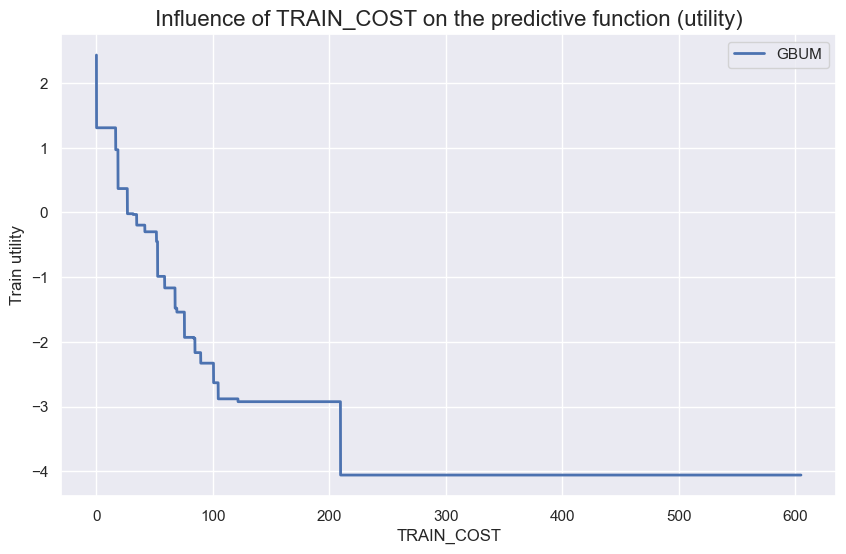

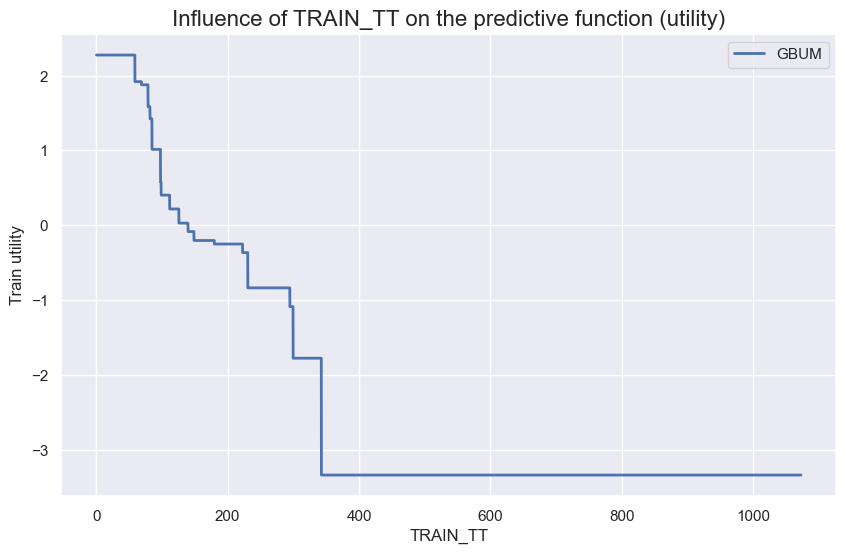

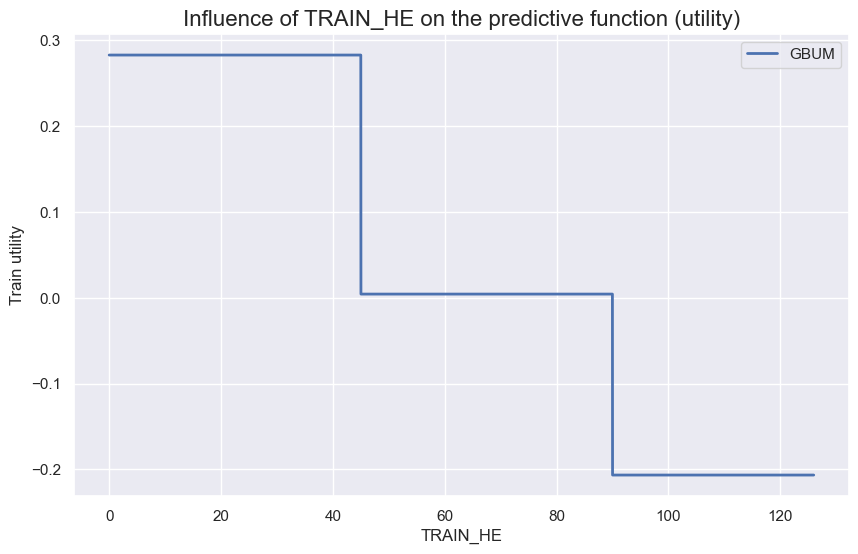

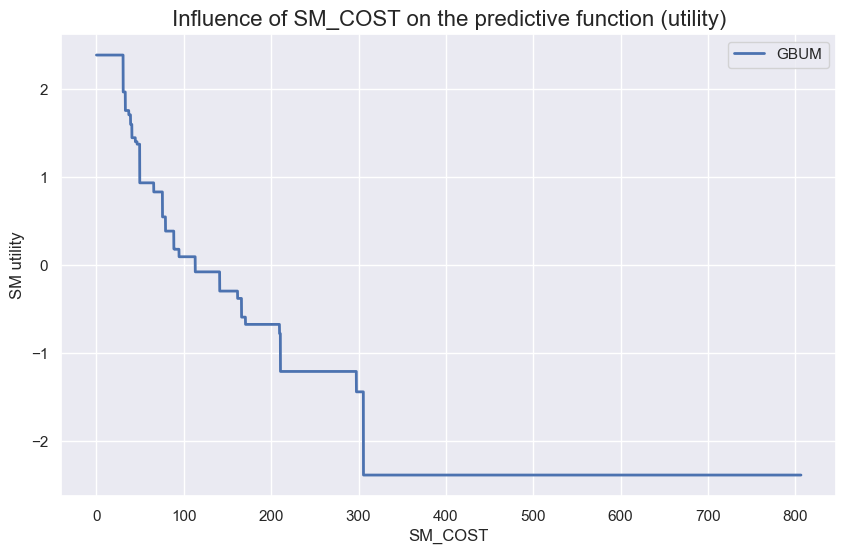

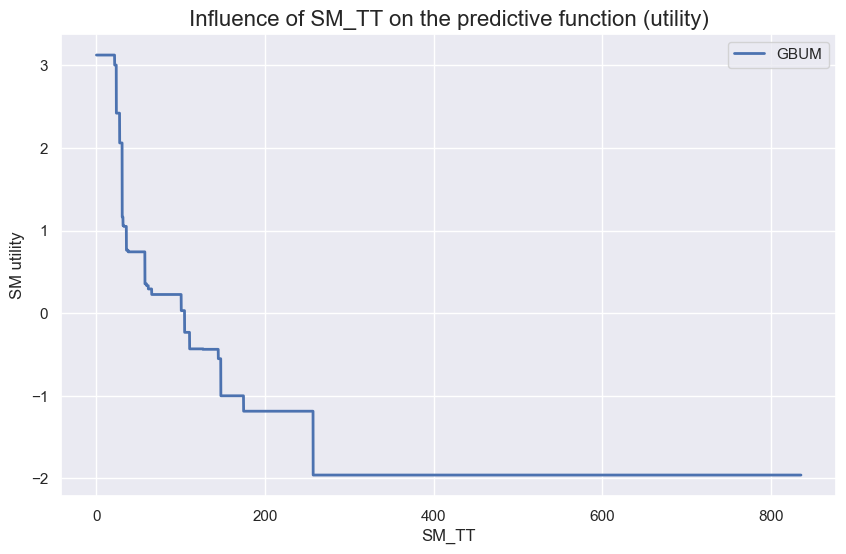

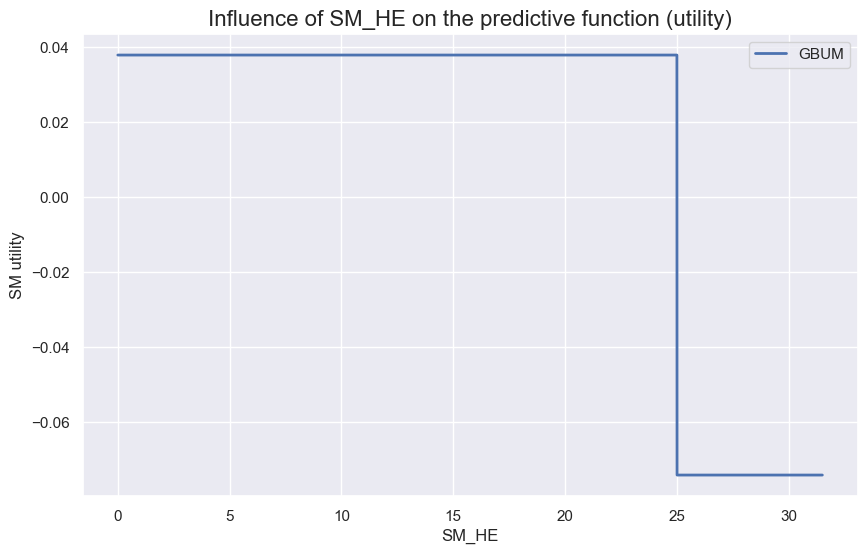

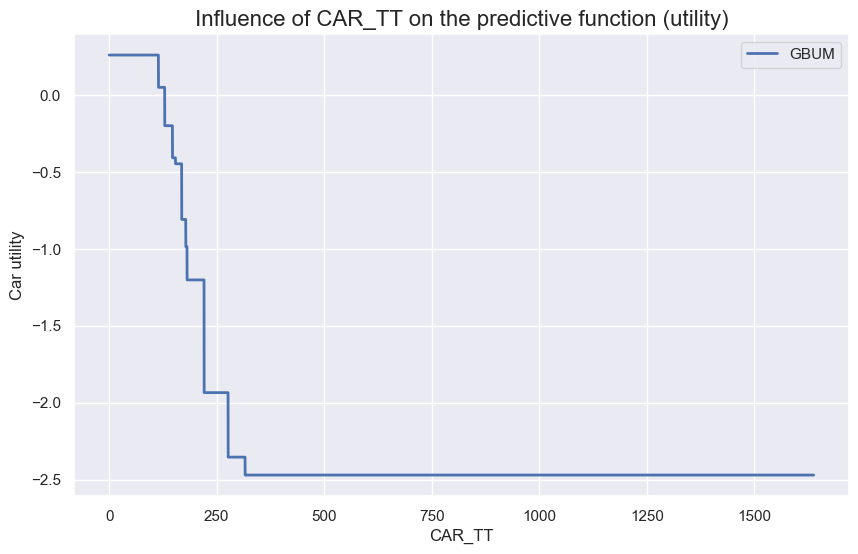

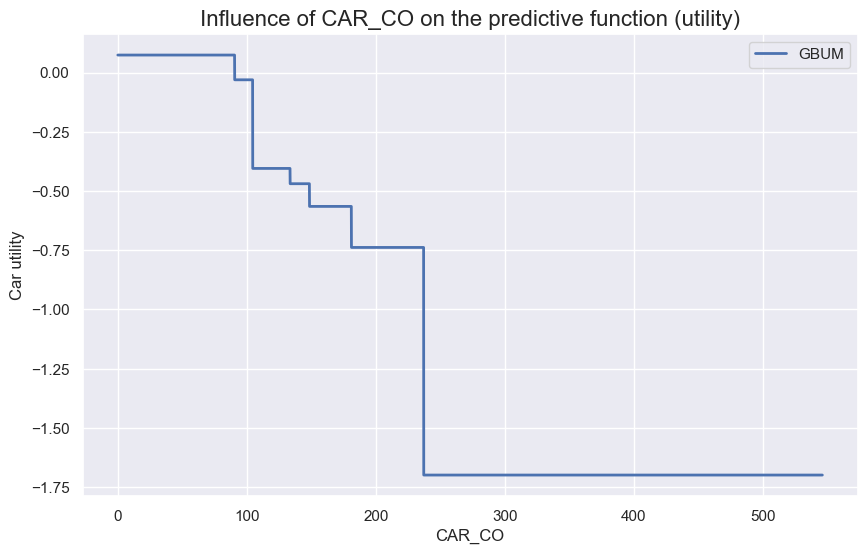

In [6]:
utility_names = {'0': 'Train', '1': 'SM', '2': 'Car'}

gbum_demo.plot_parameters(params, df_train, utility_names)